<div style="width: 100%; max-width: 100%; background-color: #f0f0f0; border: 2px solid #333; border-radius: 10px; padding: 20px; font-family: Arial, sans-serif; box-sizing: border-box;">
  <h2 style="color: #18453B; text-align: center;">Homework 04: Imputation</h2>
  
  <p style="color: #34495e; line-height: 1.6;">
    This HW is lighter than others to allow you to complete your project. Only 40 points total. 
  </p>
  
  <!-- <div style="background-color: #6FC276; color: white; padding: 10px; margin-top: 20px; text-align: center; border-radius: 5px;">
    <strong>Tip:</strong> Plan carefully!
  </div> -->
</div>

<div style="width: 100%; max-width: 100%; background-color: #fefefe; border: 1px solid #333; border-radius: 10px; padding: 20px; font-family: Arial, sans-serif; box-sizing: border-box;">
  <h3 style="color: #18453B; text-align: center;">Problem 1: Test of MCAR Missingness (10 points)</h3>
  
  <p style="color: #34495e; line-height: 1.6;">
    A crucial first step before imputation is testing for the quality/mechanism of missingness. We typically start with a test for MCAR since that might be the easiest to repair, perhaps using a deletion method. Although we have mentioned this many times in the lecture, we have not actually discussed how to do it. 
    The plan for this HW problem is for you to learn and implement highly simplifed versions of two methods: the Expectation-Maximization (EM) and Little's MCAR Test methods. In the the real-world you would use libraries (https://pypi.org/project/missingpy/) for these, and not use a simplified approach, but then you would also not know what you are doing. This HW shows you what these methods are doing so that you can intelligently use full libraries. 
  </p>
  
  <ul style="color: #34495e; line-height: 1.6;">
    <li>Write Python code that reads the iris dataset.</li>
    <li>Make a heatmap of the correlation marix of the four numeric input features; this is the ground truth.</li>
    <li>Pick a column (e.g., `sepal width`) and randomly replace the values with `NaN`.</li>
    <li>Make a new heatmap and compare it with the original.</li>
    <li>Find the mean and variance of the (remaining) values in that column.</li>
    <li>Sample a normal distribution function with that mean and variance and create a new, fixed data matrix. This is the first step in the EM method: in a full implementation you would iterate new versions until convergence. 
    <li>Make yet a new heatmap. Note that you imputed in the previous (simplified) EM step completely at random: you literally used a random number generator with no bias. 
    <li>Compare the imputed-data heatmap to the heatmap from the data with missing values. Did the imputation, done completely at random,  change the correlation structure? This is the essence of Little's MCAR Test: the missing values are assumed to be MCAR, so you fill them accordingly and then see if that assumption is reasonable. (The Little Test is normally cast as a hypothesis test with a p value.) 
    <li>Once your have a working code, play with various choices and write down what you see. That is, change the column, change the percentage missing, etc. 
    <li>In a markdown cell, summarize what you learned and what advice you would give to your future self when you are working on data science projects. 
  </ul>

  I will give you some helper code to start with! If you use it, add detailed comments.
  
  <!-- <div style="background-color: #6FC276; color: white; padding: 10px; margin-top: 20px; text-align: center; border-radius: 5px;">
    <strong>Tip:</strong> Plan carefully!
  </div> -->
</div>

In [57]:
# * Correlation analysis -https://stackoverflow.com/questions/66572672/correlation-heatmap-in-plotly
import plotly.express as px 
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Started here - imported from HW 3
def plot_better_heatmap(df, title):
    # Correlation
    df_corr = df.corr().round(2)  
    # Mask to matrix
    mask = np.zeros_like(df_corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    # Viz
    df_corr_viz = df_corr.mask(mask).dropna(how='all').dropna(axis='columns', how='all')

    fig = px.imshow(df_corr_viz, text_auto=True, title=title, color_continuous_scale='viridis', width=500, height=500)
    fig.show()


# Scaling with Claud Sonnect 4.5, 10-3-25, https://claude.ai/public/artifacts/a48c02b9-488c-4c48-95ed-ee4996f3a921
def plot_better_heatmap_subplots(df_lst, title_lst):
    fig = make_subplots(
        rows=1, 
        cols=len(df_lst),
        subplot_titles=title_lst,
        horizontal_spacing=0.1
    )

    for i, (df, title) in enumerate(zip(df_lst, title_lst), start=1):
        df_corr = df.corr().round(2)  
        # Mask to matrix
        mask = np.zeros_like(df_corr, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        # Viz
        df_corr_viz = df_corr.mask(mask).dropna(how='all').dropna(axis='columns', how='all')

        # Create heatmap trace
        fig.add_trace(
            go.Heatmap(
                z=df_corr_viz.values,
                x=df_corr_viz.columns,
                y=df_corr_viz.index,
                colorscale='viridis',
                text=df_corr_viz.values,
                texttemplate='%{text:.2f}',
                showscale=(i == len(df_lst))  # Only show colorbar on last subplot
            ),
            row=1, 
            col=i
        )

    # Update layout
    fig.update_layout(
        height=500,
        width=500 * len(df_lst),
        showlegend=False
    )
    
    fig.show()

In [58]:
### ANSWER

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets

# Get the data
iris = datasets.load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# missing values in one column (sepal width)
def introduce_missingness_in_column(dataframe, column, missing_rate=0.3):
    df_missing = dataframe.copy()

    # When the random value at the entry position is below 0.3, mask = 1
    mask = np.random.rand(df_missing.shape[0]) < missing_rate

    # set these positions to nan
    df_missing.loc[mask, column] = np.nan
    return df_missing

# put missingness in every column
df_missing = introduce_missingness_in_column(df, 'sepal width (cm)', missing_rate=0.3)

# mean and variance of remaining values in 'sepal width'
mean_val = df_missing['sepal width (cm)'].mean()
std_val = df_missing['sepal width (cm)'].std()

# impute missing values using randn (Poor Man's EM)

# get missing indices
missing_indices = df_missing['sepal width (cm)'].isna()
df_imputed = df_missing.copy()

# put in random values sampled from a normal curve with same stats as original
df_imputed.loc[missing_indices, 'sepal width (cm)'] = np.random.randn(missing_indices.sum()) * std_val + mean_val

plot_better_heatmap_subplots([df, df_missing, df_imputed],["Full Dataset Correlation Matrix", "Correlation Matrix with Missing Values (30%)",  "Correlation Matrix After Imputation"])


## Different Missingness Rates

In [59]:
df_missing = introduce_missingness_in_column(df, 'sepal width (cm)', missing_rate=0.7)

missing_indices = df_missing['sepal width (cm)'].isna()
df_imputed = df_missing.copy()

# put in random values sampled from a normal curve with same stats as original
df_imputed.loc[missing_indices, 'sepal width (cm)'] = np.random.randn(missing_indices.sum()) * std_val + mean_val

plot_better_heatmap_subplots([df, df_missing, df_imputed],["Full Dataset Correlation Matrix", "Correlation Matrix with Missing Values (30%)",  "Correlation Matrix After Imputation"])

In [60]:
df_missing = introduce_missingness_in_column(df, 'sepal width (cm)', missing_rate=0.1)

missing_indices = df_missing['sepal width (cm)'].isna()
df_imputed = df_missing.copy()

# put in random values sampled from a normal curve with same stats as original
df_imputed.loc[missing_indices, 'sepal width (cm)'] = np.random.randn(missing_indices.sum()) * std_val + mean_val

plot_better_heatmap_subplots([df, df_missing, df_imputed],["Full Dataset Correlation Matrix", "Correlation Matrix with Missing Values (30%)",  "Correlation Matrix After Imputation"])

## Different Columns

In [61]:
missing_lst = ['sepal length (cm)', 'petal length (cm)']

for missing_col in missing_lst: 
    df_missing = introduce_missingness_in_column(df, missing_col, missing_rate=0.3)

    missing_indices = df_missing[missing_col].isna()
    df_imputed = df_missing.copy()

    # put in random values sampled from a normal curve with same stats as original
    df_imputed.loc[missing_indices, missing_col] = np.random.randn(missing_indices.sum()) * std_val + mean_val

    plot_better_heatmap_subplots([df, df_missing, df_imputed],["Full Dataset Correlation Matrix", "Correlation Matrix with Missing Values (30%)",  "Correlation Matrix After Imputation"])

✏️ **Answer:** Put your reflections here

The Expectation maximization test was extremely bad for this example. Across almost all columns at several different missingness rates, the imputed dataset had correlations that were worse than the dataset with missing values. This is likely because the distributions of the features are different from just a regular normal curve, they may be skewed or have other complications. It might be a good idea to use some domain knowledge about the usual distribution of specific features to tailor the imputation curve.

<div style="width: 100%; max-width: 100%; background-color: #fefefe; border: 1px solid #333; border-radius: 10px; padding: 20px; font-family: Arial, sans-serif; box-sizing: border-box;">
  <h3 style="color: #18453B; text-align: center;">Problem 2: Correlations and MAR Missingness (10 points)</h3>
  
  <p style="color: #34495e; line-height: 1.6;">
    Next, we will do the same set of steps as in the previous problem, but now for MAR. To make this easy, you will use almost everything you just did in the previous problem. That is, use the iris dataset, make correlation heatmaps, and so on. The difference is that you will not create the missing values radnomly but according to some pattern in another column. 
  </p>
  
  <ul style="color: #34495e; line-height: 1.6;">
    <li>Copy your code from problem 1 to here and get ready to modify it.</li>
    <li>Pick a column to add missing values to.</li>
    <li>Add the missing values, `np.nan`, to the column based on values in one of the other columns. You can do this however you want, but an easy way to start is by creating missing values when the value in another column is above a certain value.</li>
    <li>Again, compare correlation heatmaps for a few choices (e,g,m columns, missingness rules, etc.).</li>
    <li>How did the correlation heatmap change for this MAR case compared with the MCAR case? 
    <li>In a markdown cell, summarize what you learned and what advice you would give to your future self when you are working on data science projects.</li>
  </ul>

  Yes, I will give you some background and code to start with! AS always, comment it if you use any of it.
  
  <!-- <div style="background-color: #6FC276; color: white; padding: 10px; margin-top: 20px; text-align: center; border-radius: 5px;">
    <strong>Tip:</strong> Plan carefully!
  </div> -->
</div>

In [62]:
### ANSWER

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets

# MAR: Make 'sepal width' missing based on 'petal length'
def introduce_MAR(dataframe, column_to_remove, reference_column, threshold):
    df_mar = dataframe.copy()
    
    # 'petal length' is above the threshold, then apply the mask to that entry
    mask = df_mar[reference_column] > threshold
    
    # add missing values in 'sepal width' where 'petal length' is above the threshold
    df_mar.loc[mask, column_to_remove] = np.nan
    return df_mar

victim_col = 'sepal width (cm)'

# set 'petal length' threshold for MAR
df_mar = introduce_MAR(df, victim_col, 'petal length (cm)', threshold=4.5)

# stats of mutilated data set
mean_val = df_mar[victim_col].mean()
std_val = df_mar[victim_col].std()

# impute missing values using randn (Poor Man's EM)

# get missing indices
missing_indices = df_mar[victim_col].isna()
df_imputed = df_mar.copy()

# put in random values sampled from a normal curve with same stats as original
df_imputed.loc[missing_indices, victim_col] = np.random.randn(missing_indices.sum()) * std_val + mean_val

# heatmap with MAR
plot_better_heatmap_subplots([df, df_mar, df_imputed],["Full Dataset Correlation Matrix", f"Correlation Matrix with {victim_col} MAR", "Correlation Matrix After Imputation"])


✏️ **Answer:** Put your reflections here

The missing at random data removes values from the sepal width feature if the petal length value get above the threshold. This moves the correlations a great deal more than the MCAR issues did. The expectation maximization method is abysmal for this kind of missingness since what distribution there was in the original data has been severely eroded in a systematic way. My hyposthesis is that the KNN imputation method might work better here since the sepal length feature might contain information to help repair the sepal width. 

<div style="width: 100%; max-width: 100%; background-color: #fefefe; border: 1px solid #333; border-radius: 10px; padding: 20px; font-family: Arial, sans-serif; box-sizing: border-box;">
  <h3 style="color: #18453B; text-align: center;">Problem 3: MAR Test (10 points)</h3>
  
  <p style="color: #34495e; line-height: 1.6;">
    Yet again, you will use the same codes from above. In problem 2 you explored MAR bit didn't actually perform a test. Let's create MAR data and create a test. As mentioned in the lecture, we can do this by creating an "indicator" variable. (This was the variable "R" in the missingness diagrams.) Again, we'll do this in a simple way so that you truly see it. In the real world you would use a machine learning classifier for this, but that isn't necessary to understand the MAR test itself. 
  </p>
  
  <ul style="color: #34495e; line-height: 1.6;">
    <li>Copy the MAR code over.</li>
    <li>Add a column to the dataframe that is either 0, not missing, or 1, missing.</li>
    <li>To test for MAR, we need to see if those 0's and 1's are correalted with values in one of the other columns.</li>
    <li>Perform that test. (Do this however you wish; it is you who needs to be convinced.)</li>
    <li>Describe what you see. Keep in mind that you used known correlations to create the MAR version of the dataset in the first place, so your test should be quite clear.</li>
  </ul>

  I will give you some background and code to start with! Don't look at it unless you plan to completely comment it! 
  
  <!-- <div style="background-color: #6FC276; color: white; padding: 10px; margin-top: 20px; text-align: center; border-radius: 5px;">
    <strong>Tip:</strong> Plan carefully!
  </div> -->
</div>

Correlation between 'sepal width missing' and 'petal length': 0.792
P-value: 0.000


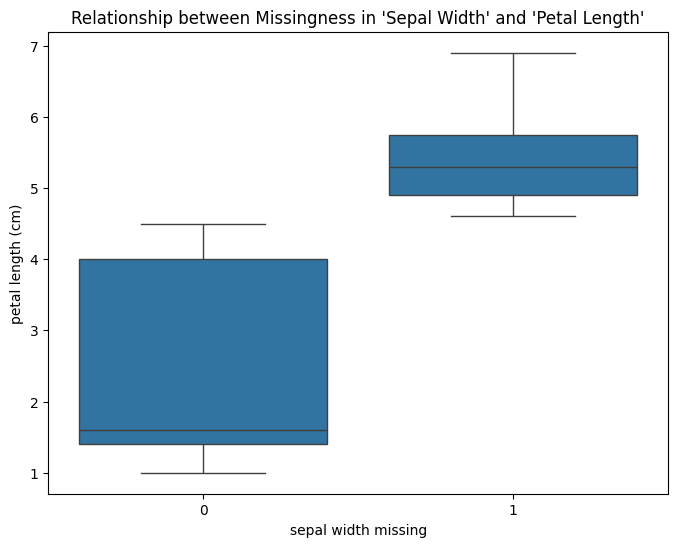

In [63]:
### ANSWER

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.stats import pearsonr

# 2. Add an indicator column for missingness in 'sepal width'
df_mar['sepal width missing'] = df_mar['sepal width (cm)'].isna().astype(int)

# 3. Check for correlation between 'sepal width missing' and 'petal length'
correlation, p_value = pearsonr(df_mar['sepal width missing'], df_mar['petal length (cm)'])

print(f"Correlation between 'sepal width missing' and 'petal length': {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

# Visualize the relationship
plt.figure(figsize=(8, 6))
sns.boxplot(x='sepal width missing', y='petal length (cm)', data=df_mar)
plt.title("Relationship between Missingness in 'Sepal Width' and 'Petal Length'")
plt.show()

✏️ **Answer:** Put your reflections here

There is no overlap between the present sepal width values that are below the threshold and the missing values above the petal length threshold. This is the ideal case where the cutoff value is clearly visible in a box and whisker plot. We can easily predict which values will be missing based off the petail length, hence the corrlation of 0.792. The chances of this happening at random, or the p-value, is 0. All of these are very strong symptoms of MAR. 

---
## <font color=#18453B> Problem #4 Update on Your Project (10 pts) </font>

![missing](https://www.crosstab.io/articles/streamlit-review/worst_case_app.png)

By now you should have decided on the main topic of your project and the data that is going to be used to inform it. (If not, do that now!)
Your project is due at midnight, **October 19.**

For this HW, answer these questions:
1. clearly articulate the goal of your project (this goal might not be reached until the second half of the semester, of which half will be done by the midterm)
2. what are the datasets you plan to use?
3. describe the data: will you need to use, for example, encoding of any kind? 
4. what is your IDA strategy? 
5. list the detailed steps of your EDA strategy
6. are there imbalances in your dataset? how will you handle this? 
7. give a detailed account of your visualization plan, including why you made the choices you did 
8. all of this will end up in a Streamlit app: describe your planned layout and logic behind it




✏️ **Answer:** Put your answers here

---
## Congratulations, you're done!

### 🛑 IMPORTANT: Before Submission

**STOP!** Before submitting your notebook, please follow these steps:

### Step 1: Restart Your Kernel

**Jupyter Notebook (Classic):**
- Go to `Kernel` → `Restart & Clear Output`

**JupyterLab:**
- Go to `Kernel` → `Restart Kernel and Clear All Outputs...`

**VS Code:**
- Open Command Palette (`Ctrl+Shift+P` / `Cmd+Shift+P`)
- Type "Jupyter: Restart" and select `Jupyter: Restart`
- Then select `Clear All Output`

**PyCharm:**
- Go to `Run` → `Restart Kernel` (or click the restart button in the toolbar)
- Go to `Cell` → `All Output` → `Clear`

### Step 2: Run All Cells

**Jupyter Notebook (Classic):**
- Go to `Cell` → `Run All`

**JupyterLab:**
- Go to `Run` → `Run All Cells`

**VS Code:**
- Open Command Palette (`Ctrl+Shift+P` / `Cmd+Shift+P`)
- Type "Jupyter: Run All" and select `Jupyter: Run All Cells`

**PyCharm:**
- Go to `Cell` → `Run All` (or use `Ctrl+Shift+F10` / `Cmd+Shift+R`)

### Step 3: Verify Everything Works

Check that all cells execute without errors and produce the expected output

This ensures that your notebook will run correctly when graded and that you haven't missed any dependencies or variable definitions that might exist only in your current session.

*Your submission will be tested in a fresh environment, so this step is crucial for full credit!*


### Step 4: Submit 
Submit this assignment by uploading your notebook to the course Desire2Learn web page.  Go to the "Homework" folder, find the appropriate submission link, and upload everything there. Make sure your name is on it!


&#169; Copyright 2025, Department of Computational Mathematics, Science and Engineering at Michigan State University.